---
title: "Análisis de proyección cambios componentes"
subtitle: "DANTOTSU"
author: "Departamento Confiabilidad"
date: today
---

In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import dagster as dg

from kdags.definitions import *
from kdags.readr import *

context = dg.build_asset_context()
from kdags.assets.planning.component_changeouts.assets import *
from IPython.display import Markdown

# from kdags.assets.reparation.reso.service_order_scraper import *

dl = DataLake(context)
msgraph = MSGraph(context)
from kdags.assets.docs.io_catalog import *
from kdags.config.catalog_loader import DATA_CATALOG
from datetime import datetime
from theme_komatsu import *
from great_tables import GT, md

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gfa_ovh_rates_df = (
    dl.read_tibble(DATA_CATALOG["gfa_overhaul_rates"]["raw_path"])
    .select(
        [
            "model_name",
            "component_name",
            "subcomponent_name",
            "mtbo",
            "gfa_overhaul_rate",
        ]
    )
    .drop_nulls("component_name")
).with_columns(gfa_overhaul_rate=pl.col("gfa_overhaul_rate").round(0).cast(pl.Int64))

2025-06-11 17:28:37 -0400 - dagster - INFO - system - Reading data from Azure path: az://bhp-raw-data/REFERENCE/gfa_overhaul_rates.xlsx
2025-06-11 17:28:38 -0400 - dagster - INFO - system - Successfully read data from: az://bhp-raw-data/REFERENCE/gfa_overhaul_rates.xlsx
2025-06-11 17:28:38 -0400 - dagster - INFO - system - Data shape: 26 rows, 7 columns


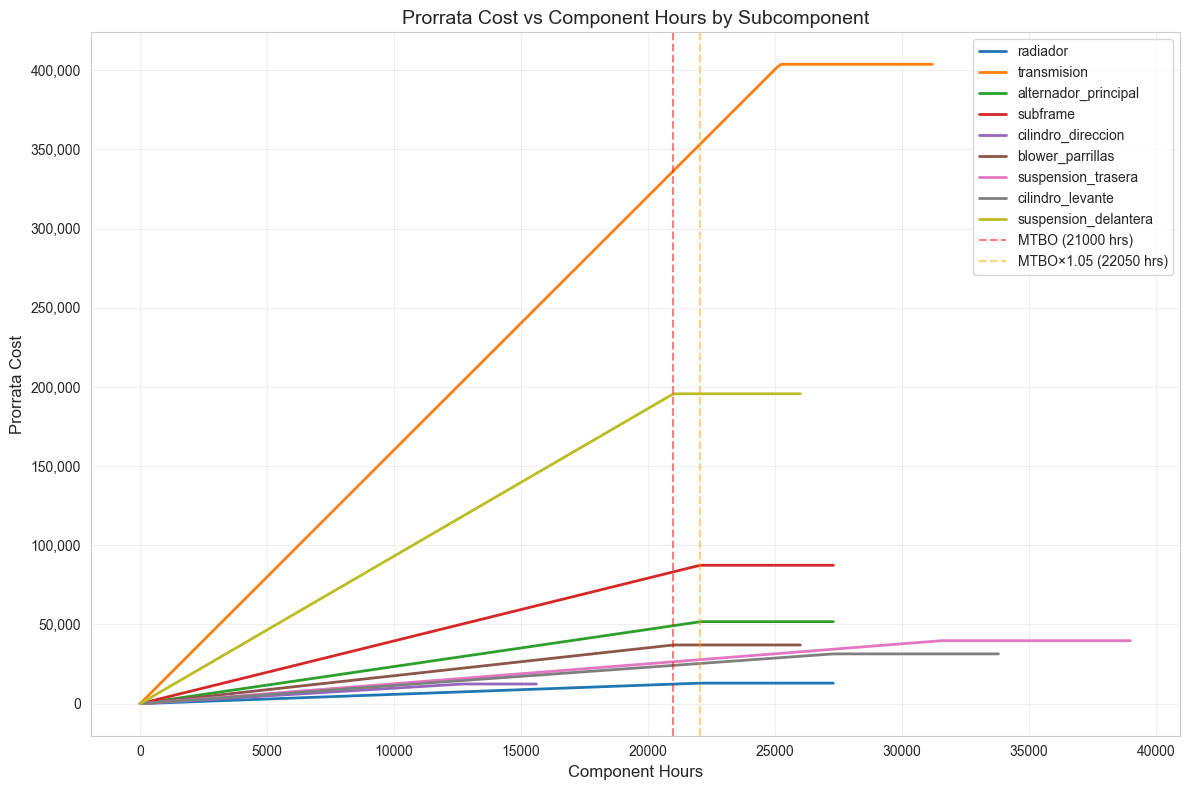


Sample of simulation data:
shape: (10, 7)
┌────────────┬───────────────┬───────────────┬───────┬───────────────┬──────────────┬──────────────┐
│ model_name ┆ component_nam ┆ subcomponent_ ┆ mtbo  ┆ gfa_overhaul_ ┆ proj_compone ┆ prorrata_sal │
│ ---        ┆ e             ┆ name          ┆ ---   ┆ rate          ┆ nt_hours     ┆ e            │
│ str        ┆ ---           ┆ ---           ┆ i64   ┆ ---           ┆ ---          ┆ ---          │
│            ┆ str           ┆ str           ┆       ┆ i64           ┆ f64          ┆ f64          │
╞════════════╪═══════════════╪═══════════════╪═══════╪═══════════════╪══════════════╪══════════════╡
│ 980E-5     ┆ modulo_potenc ┆ alternador_pr ┆ 21000 ┆ 49323         ┆ 0.0          ┆ 0.0          │
│            ┆ ia            ┆ incipal       ┆       ┆               ┆              ┆              │
│ 980E-5     ┆ modulo_potenc ┆ alternador_pr ┆ 21000 ┆ 49323         ┆ 137.18593    ┆ 322.0        │
│            ┆ ia            ┆ incipal       ┆  

In [13]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np


def simulate_prorrata_costs(components_data, hours_resolution=100):
    """
    Simulate prorrata costs for components across a range of hours

    Args:
        components_data: Either a Polars DataFrame or list of dictionaries with component information
        hours_resolution: Number of points to simulate (default 100)

    Returns:
        DataFrame with simulated data for all components
    """

    all_simulations = []

    # Convert DataFrame to list of dictionaries if needed
    if isinstance(components_data, pl.DataFrame):
        components_list = components_data.to_dicts()
    else:
        components_list = components_data

    for component in components_list:
        # Create range of hours from 0 to mtbo*1.3
        max_hours = component["mtbo"] * 1.3
        hours_range = np.linspace(0, max_hours, hours_resolution)

        # Create temporary dataframe for this component
        temp_df = pl.DataFrame(
            {
                "model_name": [component["model_name"]] * hours_resolution,
                "component_name": [component["component_name"]] * hours_resolution,
                "subcomponent_name": [component["subcomponent_name"]]
                * hours_resolution,
                "mtbo": [component["mtbo"]] * hours_resolution,
                "gfa_overhaul_rate": [component["gfa_overhaul_rate"]]
                * hours_resolution,
                "proj_component_hours": hours_range,
            }
        )

        # Apply the prorrata calculation
        result_df = calculate_prorrata_sale(temp_df)
        all_simulations.append(result_df)

    # Combine all simulations
    return pl.concat(all_simulations)


def calculate_prorrata_sale(df):
    """
    Calculate prorrata_sale (Costo Prorrata) using vectorized Polars operations
    """
    result_df = df.with_columns(
        [
            # Calculate effective hours: M = MIN(component_hours, mtbo*1.05)
            pl.min_horizontal(
                [pl.col("proj_component_hours"), pl.col("mtbo") * 1.05]
            ).alias("effective_hours"),
            # Apply prorrata formula
            pl.when(
                # Condition: effective_hours >= mtbo AND effective_hours <= mtbo*1.05
                (
                    pl.min_horizontal(
                        [pl.col("proj_component_hours"), pl.col("mtbo") * 1.05]
                    )
                    >= pl.col("mtbo")
                )
                & (
                    pl.min_horizontal(
                        [pl.col("proj_component_hours"), pl.col("mtbo") * 1.05]
                    )
                    <= pl.col("mtbo") * 1.05
                )
            )
            .then(
                # Case 1: Hours in normal range (100% to 105%)
                pl.col("gfa_overhaul_rate")
                * (
                    1
                    + (
                        (
                            pl.min_horizontal(
                                [pl.col("proj_component_hours"), pl.col("mtbo") * 1.05]
                            )
                            - pl.col("mtbo")
                        )
                        / pl.col("mtbo")
                    )
                )
            )
            .otherwise(
                # Case 2: Hours outside normal range
                pl.col("gfa_overhaul_rate")
                * (
                    pl.min_horizontal(
                        [pl.col("proj_component_hours"), pl.col("mtbo") * 1.05]
                    )
                    / pl.col("mtbo")
                )
            )
            .fill_null(0.0)
            .round(0)
            .alias("prorrata_sale"),
        ]
    ).drop(["effective_hours"])

    return result_df


def plot_prorrata_costs(simulation_df, component_name=None):
    """
    Create line plot for prorrata cost of a single component

    Args:
        simulation_df: DataFrame with simulation results
        component_name: Specific subcomponent to plot. If None, plots the first one.

    Returns:
        matplotlib figure
    """
    # Get unique components
    components = (
        simulation_df.select(["subcomponent_name"])
        .unique()["subcomponent_name"]
        .to_list()
    )

    # Select component to plot
    if component_name is None:
        component_name = components[0]
    elif component_name not in components:
        raise ValueError(
            f"Component '{component_name}' not found. Available: {components}"
        )

    # Filter data for selected component
    component_data = simulation_df.filter(pl.col("subcomponent_name") == component_name)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the component
    hours = component_data["proj_component_hours"].to_numpy()
    costs = component_data["prorrata_sale"].to_numpy()
    mtbo = component_data["mtbo"][0]

    ax.plot(hours, costs, label=component_name, linewidth=3, color="blue")

    # Add vertical lines at key points
    ax.axvline(
        x=mtbo * 0.85,
        color="green",
        linestyle="--",
        alpha=0.7,
        linewidth=2,
        label=f"85% MTBO ({mtbo*0.85:.0f} hrs)",
    )
    ax.axvline(
        x=mtbo,
        color="red",
        linestyle="--",
        alpha=0.7,
        linewidth=2,
        label=f"MTBO ({mtbo:,} hrs)",
    )
    ax.axvline(
        x=mtbo * 1.05,
        color="orange",
        linestyle="--",
        alpha=0.7,
        linewidth=2,
        label=f"105% MTBO ({mtbo*1.05:.0f} hrs)",
    )

    # Formatting
    ax.set_xlabel("Component Hours", fontsize=14)
    ax.set_ylabel("Prorrata Cost", fontsize=14)
    ax.set_title(f"Prorrata Cost vs Component Hours\n{component_name}", fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)

    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:,.0f}"))

    # Set x-axis limits to show full range
    ax.set_xlim(0, max(hours))

    plt.tight_layout()
    return fig


def plot_all_components_separately(simulation_df):
    """
    Create individual plots for each component in the simulation

    Args:
        simulation_df: DataFrame with simulation results

    Returns:
        List of matplotlib figures
    """
    components = (
        simulation_df.select(["subcomponent_name"])
        .unique()["subcomponent_name"]
        .to_list()
    )
    figures = []

    for component in components:
        fig = plot_prorrata_costs(simulation_df, component)
        figures.append(fig)

    return figures


# Simulate the data
simulation_df = simulate_prorrata_costs(
    gfa_ovh_rates_df.filter(pl.col("model_name") == "980E-5"), hours_resolution=200
)

fig = plot_prorrata_costs(simulation_df, "alternador_principal")
plt.show()

In [12]:
gfa_ovh_rates_df.schema

Schema([('model_name', String),
        ('component_name', String),
        ('subcomponent_name', String),
        ('mtbo', Int64),
        ('gfa_overhaul_rate', Int64)])

In [8]:
gfa_ovh_rates_df.filter(pl.col("model_name") == "980E-5")

model_name,component_name,subcomponent_name,mtbo,gfa_overhaul_rate
str,str,str,i64,i64
"""980E-5""","""modulo_potencia""","""alternador_principal""",21000,49323
"""980E-5""","""modulo_potencia""","""radiador""",21000,12352
"""980E-5""","""modulo_potencia""","""subframe""",21000,83223
"""980E-5""","""motor_traccion""","""transmision""",24000,384458
"""980E-5""","""blower_parrillas""","""blower_parrillas""",20000,35303
"""980E-5""","""cilindro_levante""","""cilindro_levante""",26000,29937
"""980E-5""","""suspension_trasera""","""suspension_trasera""",30000,37871
"""980E-5""","""conjunto_maza_suspension""","""suspension_delantera""",20000,186335
"""980E-5""","""cilindro_direccion""","""cilindro_direccion""",12000,11834


In [5]:
components_data

[{'model_name': '960E',
  'component_name': 'modulo_potencia',
  'subcomponent_name': 'alternador_principal',
  'mtbo': 16500,
  'gfa_overhaul_rate': 41320},
 {'model_name': '960E',
  'component_name': 'modulo_potencia',
  'subcomponent_name': 'radiador',
  'mtbo': 16500,
  'gfa_overhaul_rate': 10808},
 {'model_name': '960E',
  'component_name': 'modulo_potencia',
  'subcomponent_name': 'subframe',
  'mtbo': 16500,
  'gfa_overhaul_rate': 80142}]